## Speaking with Plato: Complete EDA

### 11/18/22

### Import libraries, functions, and data


In [15]:
%load_ext watermark
%watermark -a 'Igor_Radovanovic' -gu 'IgorWounds' -ws 'igorradovanovic.com' -m --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Igor_Radovanovic

Github username: IgorWounds

Website: igorradovanovic.com

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

matplotlib  : None
nltk        : 3.6.5
seaborn     : 0.11.2
tensorflow  : 2.6.0
sys         : 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]
pandas      : 1.4.3
text2emotion: 0.0.5
numpy       : 1.19.5
gensim      : 4.2.0
tensorboard : 2.6.0
pyLDAvis    : 3.3.1



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

try:
    nltk.data.find("vader_lexicon")
except LookupError:
    nltk.download("vader_lexicon")
try:
    nltk.data.find("brown")
except LookupError:
    nltk.download("brown")

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

import tensorflow as tf
from tensorboard.plugins import projector
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

import text2emotion as te
from textblob import TextBlob

import sys
import os
import re

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/visualization")

from visualize import polarity_and_subjectivity, wordcloud, get_top_bigrams

import warnings

warnings.filterwarnings("ignore")

In [2]:
# load the data
df = pd.read_csv("../data/processed/plato_texts.csv").T
df.columns = ["text"]
df.head()

,text
alcibiades_i,socrates: i dare say that you may be surprised...
alcibiades_ii,persons of the dialogue: socrates and alcibiad...
apology,"apology how you, o athenians, have been affect..."
charmides,"persons of the dialogue: socrates, who is the ..."
cratylus,"persons of the dialogue: socrates, hermogenes,..."


### Sentiment Analysis using VADER


In [ ]:
sia = SIA()
results = []

for text in df["text"]:
    pol_score = sia.polarity_scores(text)
    pol_score["text"] = text
    # append only the negative, neutral, compund, and positive scores
    results.append(
        {k: v for k, v in pol_score.items() if k in ["neg", "neu", "compound", "pos"]}
    )

df["compund"] = [result["compound"] for result in results]
df["negative"] = [result["neg"] for result in results]
df["neutral"] = [result["neu"] for result in results]
df["positive"] = [result["pos"] for result in results]
df.head()

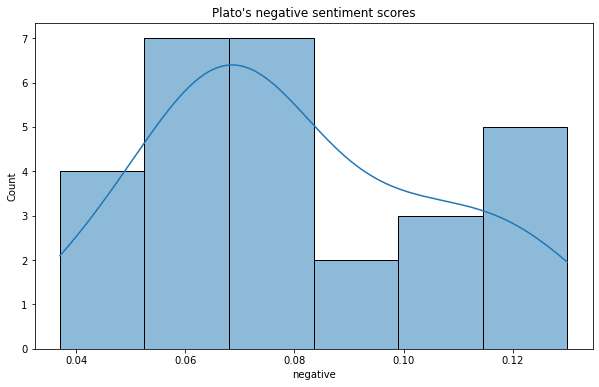

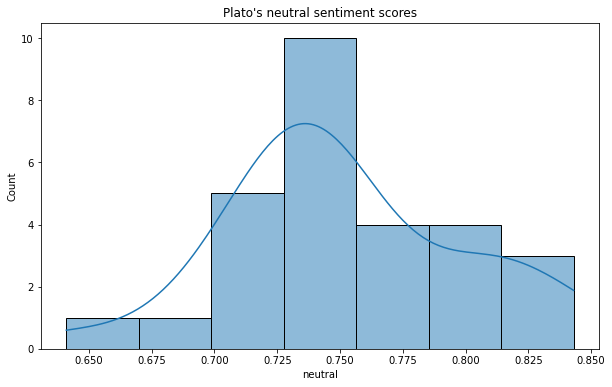

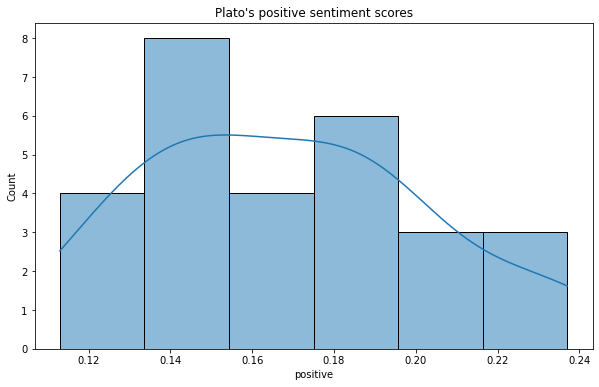

In [5]:
for col in ["negative", "neutral", "positive"]:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"Plato's {col} sentiment scores")
    plt.savefig(f"../reports/figures/{col}_sentiment_scores.png")
    plt.show()

In [ ]:
cols = ["negative", "neutral", "positive"]

for col in cols:
    plt.figure(figsize=(10, 6))
    try:
        sns.catplot(
            x=col, y=df.index, data=df, order=df.sort_values(col).index
        )
        plt.title(f"Plato's {col.capitalize} Sentiment Scores")
    except ValueError:
        pass
    plt.tight_layout()
    plt.savefig(f"../reports/figures/compared_{col}_sentiment_scores.png")

### Polarity and subjectivity


In [ ]:
# create a polarity and subjectivity graph for each text in df
for i, text in enumerate(df["text"]):
    polarity_and_subjectivity(
        text,
        f"Plato's {df.index[i].capitalize().replace('_ii', ' II').replace('_i', ' I')}",
        f"../reports/figures/pol_and_sub/{df.index[i]}_polarity_and_subjectivity.png",
    )

In [8]:
# calculate polarity and subjectivity
polarity = []
subjectivity = []

for text in df["text"]:
    blob = TextBlob(text)
    polarity.append(blob.polarity)
    subjectivity.append(blob.subjectivity)

df["polarity"] = polarity
df["subjectivity"] = subjectivity

# plot the polarity and subjectivity scores for each text in df
for col in ["polarity", "subjectivity"]:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"Plato's {col} scores")
    plt.savefig(f"../reports/figures/{col}_scores.png")
    plt.show()

<Figure size 720x720 with 0 Axes>

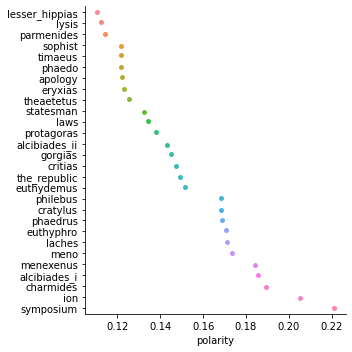

In [15]:
# plot catplot of polarity and subjectivity scores for each text in df
plt.figure(figsize=(10, 10))
try:
    sns.catplot(
        x="polarity", y=df.index, data=df, order=df.sort_values("polarity").index
    )
    plt.title("Plato's Polarity Scores")
except ValueError:
    pass
plt.tight_layout()
plt.savefig(f"../reports/figures/compared_polarity_scores.png")

<Figure size 720x720 with 0 Axes>

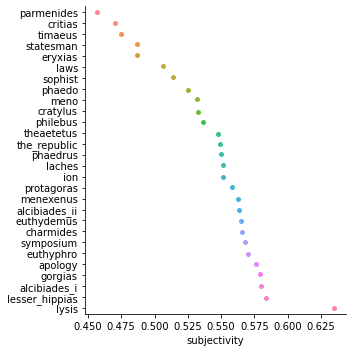

In [16]:
# plot catplot of polarity and subjectivity scores for each text in df
plt.figure(figsize=(10, 10))
try:
    sns.catplot(
        x="subjectivity",
        y=df.index,
        data=df,
        order=df.sort_values("subjectivity").index,
    )
    plt.title("Plato's Subjectivity Scores")
except ValueError:
    pass
plt.tight_layout()
plt.savefig(f"../reports/figures/compared_subjectivity_scores.png")

### Top Sentences


In [33]:
for i, text in enumerate(df["text"]):
    dir = "../reports/files/"
    blob = TextBlob(text)
    # remove whole sentence starting with "persons" in blob.sentences
    blob.sentences = [
        sentence
        for sentence in blob.sentences
        if not re.match(r"persons", str(sentence))
    ]
    if not os.path.exists(dir):
        os.makedirs(dir)
    with open(dir + "polarization_and_subjectivity.txt", "a") as f:
        f.write(
            f"Plato's {df.index[i].capitalize().replace('_ii', ' II').replace('_i', ' I')}"
        )
        f.write("\n")
        f.write(
            f"Top sentence with the highest polarity score: {blob.sentences[np.argmax([sentence.polarity for sentence in blob.sentences])]}"
        )
        f.write("\n")
        f.write(
            f"Top sentence with the lowest polarity score: {blob.sentences[np.argmin([sentence.polarity for sentence in blob.sentences])]}"
        )
        f.write("\n")
        f.write(
            f"Top sentence with the highest subjectivity score: {blob.sentences[np.argmax([sentence.subjectivity for sentence in blob.sentences])]}"
        )
        f.write("\n")
        f.write(
            f"Top sentence with the lowest subjectivity score: {blob.sentences[np.argmin([sentence.subjectivity for sentence in blob.sentences])]}"
        )
        f.write("\n")
        f.write("\n")

### Emotion Analysis


In [ ]:
# calculate emotion scores
anger = []
fear = []
happy = []
sad = []
surprise = []
i = 0
for text in df["text"]:
    print(i)
    i += 1
    emotions = te.get_emotion(text)
    anger.append(emotions["Angry"])
    fear.append(emotions["Fear"])
    happy.append(emotions["Happy"])
    sad.append(emotions["Sad"])
    surprise.append(emotions["Surprise"])

df["anger"] = anger
df["fear"] = fear
df["happy"] = happy
df["sad"] = sad
df["surprise"] = surprise

df.head()

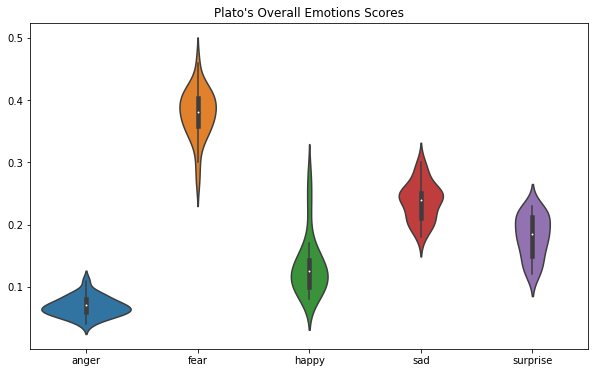

In [5]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[["anger", "fear", "happy", "sad", "surprise"]])
plt.title("Plato's Overall Emotions Scores")
plt.savefig(f"../reports/figures/emotion_scores.png")

In [ ]:
# plot anger scores for each text in df as a catplot
cols = ["anger", "fear", "happy", "sad", "surprise"]
for col in cols:
    plt.figure(figsize=(10, 10))
    try:
        sns.catplot(x=col, y=df.index, data=df, order=df.sort_values(col).index)
        plt.title(f"Plato's {col.capitalize()} Scores")
    except ValueError:
        pass
    plt.tight_layout()
    plt.savefig(f"../reports/figures/comparison/compared_{col}_scores.png")

In [ ]:
for i, text in enumerate(df["text"]):
    cols = ["anger", "fear", "happy", "sad", "surprise"]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cols, y=df.iloc[i][cols])
    plt.title(
        f"Plato's {df.index[i].capitalize().replace('_ii', ' II').replace('_i', ' I')} Emotion Scores"
    )
    plt.tight_layout()
    plt.savefig(f"../reports/figures/emotions/{df.index[i]}_emotion_scores.png")
    plt.show()

In [ ]:
df.head()

In [11]:
df.to_csv("../data/processed/processed_plato_texts.csv")

### Additional data cleaning


In [4]:
# remove punctuation
df["text"] = df["text"].str.replace("[^\w\s]", "")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# remove stopwords from each text
df["text"] = df["text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop_words)])
)
# lemmatize each text
df["text"] = df["text"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

df.head()

,text
alcibiades_i,socrates dare say may surprised find son clein...
alcibiades_ii,person dialogue socrates alcibiades socrates g...
apology,apology athenian affected accuser cannot tell ...
charmides,person dialogue socrates narrator charmides ch...
cratylus,person dialogue socrates hermogenes cratylus h...


### Wordclouds


In [ ]:
# create a wordcloud for each text in df

for i in df.index:
    title = i.capitalize().replace("_ii", " II").replace("_i", " I")
    wordcloud(
        df["text"][i], title=title, save_path=f"../reports/figures/{i}.png", save=True
    )

### Topic Modeling


In [172]:
def perform_lda(df, num_topics):
    stop_words = set(stopwords.words("english"))
    stop_words.update(["u", "one"])

    texts = [text.split() for text in df["text"]]
    texts = [[word for word in text if word not in stop_words] for text in texts]
    texts = [[lemmatizer.lemmatize(word) for word in text] for text in texts]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)
    lda_display = gensimvis.prepare(
        lda_model,
        corpus,
        dictionary,
    )
    return lda_display

In [173]:
# perform LDA on all texts combined
lda_display = perform_lda(df, num_topics=10)
pyLDAvis.save_html(lda_display, f"../reports/files/lda/all_texts_combined.html")

In [167]:
# perform lda on each text separately
for i, text in enumerate(df["text"]):
    lda_display = perform_lda(df.iloc[i : i + 1], num_topics=5)
    pyLDAvis.save_html(lda_display, f"../reports/files/lda/{df.index[i]}.html")

In [ ]:
# create a chart that represents the top bigrams for each text in df

# adding a few stopwords to the default list
ignore = [
    "socrates",
    "alcibiades",
    # 'critias',
    # 'hermogenes',
    # 'callicles',
    # 'dynodorus',
    # 'protarchus',
    "phaedrus",
    "thaetetus",
    # 'eriximachus',
    # 'menexenus',
    # 'cleinias'
    "u",
    "one",
]

stop_words = set(stopwords.words("english"))
stop_words.update(ignore)

for i, text in enumerate(df["text"]):
    get_top_bigrams(
        text,
        title=(
            f"Top {10} Bigrams in Plato's {df.index[i].capitalize().replace('_ii', ' II').replace('_i', ' I')}"
        ),
        n=10,
        stop_words=stop_words,
        save_path=f"../reports/figures/top_bigrams/{df.index[i]}_bigrams.png",
    )

### Word Embeddings Analysis


In [ ]:
%load_ext tensorboard

for i, text in enumerate(df['text'][:1]):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['u'])
    text = [word for word in text.split() if word not in (stop_words)]
    texts = [text.split() for text in df['text']]
    # create a word2vec model
    model = Word2Vec(texts, vector_size=100, window=5, min_count=1, workers=4)
    # create a list of words
    words = list(model.wv.index_to_key)
    # create a list of vectors
    vectors = [model.wv[word] for word in words]
    tsne = TSNE(n_components=2)
    vectors_2d = tsne.fit_transform(vectors)
    # create a dataframe of words and 2d vectors make sure that the exact word is a label for each vector
    df_2d = pd.DataFrame(vectors_2d, index=words, columns=['y', 'x'])

    # create a tensorboard writer
    writer = tf.summary.create_file_writer(f'../reports/files/tensorboard_embeddings/{df.index[i]}')
    # Set up a logs directory, so Tensorboard knows where to look for files.
    try: 
        os.makedirs(f'../reports/files/tensorboard_embeddings/{df.index[i]}')
    except FileExistsError:
        pass
    
    log_dir = f'../reports/files/tensorboard_embeddings/{df.index[i]}'
    with open(os.path.join(log_dir, 'metadata.tsv'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')
    
    weights = tf.Variable(vectors_2d)
    checkpoint = tf.train.Checkpoint(embedding=weights)
    checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
    embedding.metadata_path = 'metadata.tsv'

    # save a config file that Tensorboard will read during startup.
    projector.visualize_embeddings(log_dir, config)


%tensorboard --logdir ../reports/files/tensorboard_embeddings